# Text mining

## Appuie pour faire tourner les fonctions

### Config

Les modules à installer se trouvent dans requirements.txt

Import and download

In [58]:
import json
import os
import re
import csv
import string
import nltk 
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


False

Configuration

In [109]:
STOP_WORDS = set(stopwords.words('english')) | set(string.punctuation)
STEMMER = nltk.stem.SnowballStemmer('english')
SIA = SentimentIntensityAnalyzer()

### Fonctions utilitaires

Chargement du fichier de contenu

In [60]:
def load_data(content_path, links_path):
    if not os.path.exists(content_path):
        raise FileNotFoundError(f"Le fichier '{content_path}' est introuvable.")
    with open(content_path, 'r', encoding='utf-8') as file:
        content = json.load(file)
    if not os.path.exists(links_path):
        raise FileNotFoundError(f"Le fichier '{links_path}' est introuvable.")
    with open(links_path, 'r', encoding='utf-8') as file:
        links = json.load(file)
    
    return content, links

Sauvegarde des données

In [61]:
os.makedirs('output', exist_ok=True)

def save_to_file(data, filename):
    if isinstance(data, np.ndarray):
        np.savetxt(f'output/{filename}.txt', data, fmt='%.4f')
    elif isinstance(data, dict):
        with open(f'output/{filename}.json', 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
    elif isinstance(data, list):
        with open(f'output/{filename}.txt', 'w', encoding='utf-8') as f:
            for line in data:
                f.write(line + '\n')


JSON TO GML

In [62]:
def json_to_gml (links_path, output_file):
    with open(links_path, "r", encoding="utf-8") as file:
        links_path = json.load(file)
    nodes = set()
    edges = []
    # Parcourir les liens et extraire les nœuds et les connexions
    for source, targets in links_path.items():
        nodes.add(source)
        for target in targets:
            nodes.add(target)
            edges.append((source, target))

    # Étape 3 : Assigner des ID aux nœuds (sans utiliser enumerate)
    node_id = {}
    current_id = 0
    for node in nodes:
        node_id[node] = current_id
        current_id += 1

    # Étape 4 : Écrire le fichier GML
    with open(output_file, "w", encoding="utf-8") as file:
        file.write("graph\n")
        file.write("[\n")
        file.write("  directed 1\n")  # Graph orienté

        # Ajouter les nœuds
        for node, id in node_id.items():
            file.write("  node\n")
            file.write("  [\n")
            file.write(f"    id {id}\n")
            file.write(f"    label \"{node}\"\n")
            file.write("  ]\n")

        # Ajouter les arêtes
        for source, target in edges:
            file.write("  edge\n")
            file.write("  [\n")
            file.write(f"    source {node_id[source]}\n")
            file.write(f"    target {node_id[target]}\n")
            file.write("  ]\n")

        file.write("]\n")

    print(f"Fichier GML créé : {output_file}")

Traitement du contenu texte

In [63]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [STEMMER.stem(token) for token in tokens if token not in STOP_WORDS and len(token) > 2]
    return tokens

Sauvegarder tous les tokens

In [64]:
def clean_and_save_tokens(content, output_file):
    cleaned_data = {}

    for page_title, page_content in content.items():
        tokens = preprocess_text(page_content)
        cleaned_data[page_title] = tokens

    save_to_file(cleaned_data, output_file)

Traitement de texte spécifique à SIA, pour éviter de supprimer les "not" et autres

In [65]:
def preprocess_SIA(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

Liste des tokens

In [66]:
def tokenize_corpus(corpus):
    all_tokens = []
    for content in corpus.values():
        all_tokens.extend(preprocess_text(content))
    return all_tokens

### Différents modèles de text mining

Trouver les phrases comprenant un ou des mots

In [67]:
def find_sentences_with_words(corpus, words):
    sentences_with_words = []
    for content in corpus.values():
        sentences = sent_tokenize(content)
        for sentence in sentences:
            if all(word in sentence.lower() for word in words):
                sentences_with_words.append(sentence)
    return sentences_with_words

Analyse de sentiment

In [104]:
def analyze_word_sentiment(sentences):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = {"positive": 0, "negative": 0, "neutral": 0, "compound": 0}
    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        sentiment_scores["positive"] += scores["pos"]
        sentiment_scores["negative"] += scores["neg"]
        sentiment_scores["neutral"] += scores["neu"]
        sentiment_scores["compound"] += scores["compound"]

    # Moyenne des scores
    num_sentences = len(sentences)
    if num_sentences > 0:
        sentiment_scores = {key: value / num_sentences for key, value in sentiment_scores.items()}

    # Déterminer le sentiment principal
    if sentiment_scores["positive"] > sentiment_scores["negative"] and sentiment_scores["positive"] > sentiment_scores["neutral"]:
        sentiment = "Positif"
    elif sentiment_scores["negative"] > sentiment_scores["positive"] and sentiment_scores["negative"] > sentiment_scores["neutral"]:
        sentiment = "Négatif"
    else:
        sentiment = "Neutre"

    return sentiment_scores, sentiment

def word_sentiment_analysis(content, word):

    # Trouver les phrases contenant le mot
    sentences_with_word = find_sentences_with_words(content, word)
    if not sentences_with_word:
        return f"Le mot '{word}' n'apparaît pas dans le corpus."

    # Analyser le sentiment des phrases
    sentiment_scores, sentiment = analyze_word_sentiment(sentences_with_word)

    return {
        "word": word,
        "sentences_with_word": sentences_with_word,
        "sentiment_scores": sentiment_scores,
        "overall_sentiment": sentiment
    }

def analyze_page_sentiment(page_name, content):
    if page_name not in content:
        return f"La page '{page_name}' n'existe pas dans le corpus."

    page_content = content[page_name]
    sentences = sent_tokenize(page_content)
    sentiment_scores, overall_sentiment = analyze_word_sentiment(sentences)

    # Ajout pour cas neutre avec consonance
    if overall_sentiment == "Neutre":
        if sentiment_scores["positive"] > sentiment_scores["negative"]:
            overall_sentiment = "Neutre avec consonance plus positive"
        elif sentiment_scores["negative"] > sentiment_scores["positive"]:
            overall_sentiment = "Neutre avec consonance plus négative"

    return {
        "page_name": page_name,
        "sentiment_scores": sentiment_scores,
        "overall_sentiment": overall_sentiment
    }


Bigrammes

In [69]:
def find_cooccurrences(corpus_path, keyword, min_freq=2, window_size=5):
    # Charger et prétraiter le corpus
    with open(corpus_path, 'r', encoding='utf-8') as file:
        corpus = json.load(file)
    
    all_tokens = []
    for text in corpus.values():
        all_tokens.extend(preprocess_text(text))
    
    # Trouver les bigrammes avec la librairie NLTK
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(all_tokens, window_size=window_size)
    finder.apply_freq_filter(min_freq)
    
    # Filtrer les bigrammes contenant le mot-clé
    keyword_stem = STEMMER.stem(keyword)
    relevant_bigrams = {}
    for bigram, freq in finder.ngram_fd.items():
        if keyword_stem in bigram:
            distances = []
            for i in range(len(all_tokens) - 1):
                if all_tokens[i] == bigram[0] and bigram[1] in all_tokens[i + 1:i + window_size + 1]:
                    j = all_tokens.index(bigram[1], i + 1, i + window_size + 1)
                    distances.append(abs(j - i))
            relevant_bigrams[bigram] = {
                "frequency": freq,
                "mean_distance": sum(distances) / len(distances) if distances else 0
            }
    
    # Trier les résultats
    sorted_bigrams = sorted(relevant_bigrams.items(), key=lambda item: item[1]['frequency'], reverse=True)
    
    # Afficher les résultats
    print(f"Cooccurrences pour le mot-clé '{keyword}':\n")
    print(f"{'Cooccurrence':<20}\t{'Frequency':<10}\t{'Mean Distance':<15}")
    print(f"{'-' * 60}")
    for bigram, data in sorted_bigrams:
        print(f"{bigram[0]} {bigram[1]:<17}\t{data['frequency']:<10}\t{data['mean_distance']:<15.2f}")
    
    return sorted_bigrams

Analyse des tokens

In [70]:
def show_top_tokens(corpus, top_n=20):
    all_tokens = tokenize_corpus(corpus)
    freq_dist = nltk.FreqDist(all_tokens)
    return freq_dist.most_common(top_n)

Wordcloud

In [71]:
def generate_wordcloud(corpus, output_filename='wordcloud.png'):
    all_tokens = tokenize_corpus(corpus)
    text = ' '.join(all_tokens)
    wordcloud = WordCloud(background_color='white', stopwords=STOP_WORDS, max_words=30, min_font_size=10).generate(text)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'output/{output_filename}', format='png')
    plt.show()

Tableau des tops tokens 

In [72]:
def generate_token_table(json_path, output_csv):
    STOP_WORDS = set(stopwords.words('english')) | set(string.punctuation)
    STEMMER = SnowballStemmer('english')
    with open(json_path, 'r', encoding='utf-8') as file:
        content = json.load(file)
    token_counts = {}  # Dictionnaire pour les occurrences
    document_counts = defaultdict(int)  # Nombre de documents contenant chaque token
    word_map = defaultdict(set)  # Mots originaux associés aux tokens stemmés


    for text in content.values():
        tokens = word_tokenize(text.lower())
        stemmed_tokens = [STEMMER.stem(token) for token in tokens if token.isalnum() and token not in STOP_WORDS]
        #Compter les occurrences globales
        for token in stemmed_tokens:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1

        #Compter les documents contenant chaque token (uniquement une fois par document)
        unique_tokens = set(stemmed_tokens)
        for token in unique_tokens:
            document_counts[token] += 1

        #Mapper les mots originaux aux tokens stemmés
        for word in tokens:
            if word.isalnum() and word not in STOP_WORDS:
                stemmed = STEMMER.stem(word)
                word_map[stemmed].add(word)

    # Construire et sauvegarder le tableau en une étape
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        
        # Écrire l'en-tête
        writer.writerow(["Token (stemmatisé)", "Mots associés", "Occurrences", "Articles concernés"])
        
        # Écrire les données
        for token, freq in token_counts.items():
            writer.writerow([
                token,
                ', '.join(word_map[token]),  # Convertir les mots associés en chaîne de caractères
                freq,
                document_counts[token]
            ])
    print(f"Tableau sauvegardé dans {output_csv}")


### Clustering

Matrice de similarité par cosinus

In [73]:

def calculate_cosine_similarity(content):
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(list(content.values()))
    
    # Calcul de la matrice de similarité par le cosinus
    similarity_matrix = cosine_similarity(X_tfidf)
    save_to_file(similarity_matrix, 'similarity_matrix')
    
    #afficher un graphe
    
    
    return similarity_matrix

Calculer le nombre optimal de clusters 
- par la méthode du coude

In [74]:
def find_optimal_clusters(content, max_k=10):
    with open(content, encoding='utf-8') as file:
        content = json.load(file)

    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(list(content.values()))
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, max_iter=100, n_init=5, random_state=42)
        kmeans.fit(X_tfidf)
        distortions.append(kmeans.inertia_)
    
    # Crée le répertoire output s'il n'existe pas
    os.makedirs('output', exist_ok=True)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel('Nombre de Clusters')
    plt.ylabel('Distorsion')
    plt.title('Méthode du Coude')
    plt.savefig('output/elbow_method.png')
    plt.show()
    
    # Retourne le nombre optimal basé sur l'inflexion
    optimal_k = np.diff(distortions).argmin() + 2
    return optimal_k

Clusters

In [75]:
def cluster_documents(content, num_clusters):
    with open(content, encoding='utf-8') as file:
        content = json.load(file)

    documents = list(content.values())
    
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(documents)
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100, n_init=10, random_state=42)
    kmeans.fit(X_tfidf)
    
    clusters = {}
    for i, doc in enumerate(documents):
        cluster_label = int(kmeans.labels_[i])
        document_key = list(content.keys())[i]  # Utilisation de la clé du dictionnaire
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(document_key)
    
    save_to_file(clusters, 'clusters.json')

    # Calcul et sauvegarde de la matrice de similarité
    similarity_matrix = calculate_cosine_similarity(content)
    
    return clusters, similarity_matrix

Sauvegarde les titres complets des documents dans chaque cluster dans un fichier

In [76]:
def save_clusters_individually(clusters, content_path):
    # Charger le contenu à partir du fichier JSON
    with open(content_path, 'r', encoding='utf-8') as f:
        content = json.load(f)

    # Créer un dossier pour stocker les fichiers des clusters
    os.makedirs('output/clusters', exist_ok=True)
    
    # Sauvegarder chaque cluster dans un fichier JSON séparé
    for cluster_label, docs in clusters.items():
        cluster_content = {doc: content[doc] for doc in docs}  # Documents de ce cluster
        output_file = f'output/clusters/cluster_{cluster_label}.json'  # Nom du fichier JSON
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(cluster_content, f, ensure_ascii=False, indent=4)
        print(f"Cluster {cluster_label} sauvegardé dans {output_file}")


Links par clusters

In [77]:
def create_links_per_cluster(clusters_dir, original_links_path, output_dir):
    # Charger les liens originaux
    with open(original_links_path, 'r', encoding='utf-8') as f:
        original_links = json.load(f)

    # Créer un répertoire pour stocker les nouveaux fichiers
    os.makedirs(output_dir, exist_ok=True)

    # Parcourir tous les fichiers de clusters dans le répertoire spécifié
    for cluster_file in os.listdir(clusters_dir):
        cluster_path = os.path.join(clusters_dir, cluster_file)

        # Charger le fichier du cluster
        with open(cluster_path, 'r', encoding='utf-8') as f:
            cluster_nodes = json.load(f)

        # Préparer un dictionnaire pour les liens de ce cluster
        cluster_links = {}

        # Parcourir les nœuds du cluster et ajouter leurs liens
        for node in cluster_nodes:
            if node in original_links:
                cluster_links[node] = [
                    target for target in original_links[node] if target in cluster_nodes
                ]

        # Nommer le fichier de sortie basé sur le fichier du cluster
        cluster_label = os.path.splitext(cluster_file)[0]
        output_path = os.path.join(output_dir, f"{cluster_label}_links.json")

        # Sauvegarder les liens filtrés dans un fichier JSON
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(cluster_links, f, ensure_ascii=False, indent=4)

        print(f"Fichier de liens créé pour le cluster : {output_path}")


Graph de similarité

In [78]:
def generate_similarity_graph(content, similarity_matrix, output_file):
    G = nx.Graph()

    # Ajouter les nœuds
    for page in content.keys():
        G.add_node(page)

    # Ajouter les arêtes pondérées par les similarités textuelles
    pages = list(content.keys())
    for i in range(len(pages)):
        for j in range(i + 1, len(pages)):
            similarity = similarity_matrix[i, j]
            if similarity > 0:  # Ajouter une arête seulement si la similarité est positive
                G.add_edge(pages[i], pages[j], weight=similarity)

    # Sauvegarder le graphe en format GML
    nx.write_gml(G, output_file)
    print(f"Graphe de similarité créé : {output_file}")

## Choisis ce que tu veux lancer

Chemin du fichier

In [79]:
if __name__ == '__main__':
    content_path = 'content3.json'
    links_path = 'links3.json'
    content, links = load_data(content_path, links_path)

Phrases content un/des mots

In [80]:
words_to_find = ['profit', 'growth']
sentences = find_sentences_with_words(content, words_to_find)
for sentence in sentences:
    print(sentence)

However, other research in the United States has found that unions can harm profitability, employment and business growth rates.
=== Depression ===
Workplace depression can occur in many companies of various size and profession, and can have negative effects on positive profit growth.
The field was initially an outgrowth of applied mathematics, where early challenges were problems relating to the optimization of systems which could be modeled linearly, i.e., determining the optima (maximum value of profit, assembly line performance, crop yield, bandwidth, etc.
He posited that the growth of population and capital, pressing against a fixed supply of land, pushes up rents and holds down wages and profits.
However, other research in the United States has found that unions can harm profitability, employment and business growth rates.
However, other research in the United States has found that unions can harm profitability, employment and business growth rates.
The field was initially an out

Analyse de sentiment

In [81]:
word = "profit"  
result = word_sentiment_analysis(content, word)

print(f"Analyse de sentiment pour le mot '{result['word']}':")
print(f"Scores moyens : {result['sentiment_scores']}")
print(f"Sentiment global : {result['overall_sentiment']}")
print("\nExemples de phrases contenant le mot :")
for sentence in result["sentences_with_word"][:5]:  # Afficher jusqu'à 5 phrases
    print(f"- {sentence}")

Analyse de sentiment pour le mot 'profit':
Scores moyens : {'positive': 0.09351939475391478, 'negative': 0.055420706274909574, 'neutral': 0.851058369635746, 'compound': 0.11642284039299398}
Sentiment global : Neutre

Exemples de phrases contenant le mot :
- Diversity, in a business context, is hiring and promoting employees from a variety of different backgrounds and identities.
- Those characteristics may include various legally protected groups, such as people of different religions or races, or backgrounds that are not legally protected, such as people from different social classes or educational levels.
- A business or group with people from a variety of backgrounds is called diverse; a business or group with people who are very similar to each other is not diverse.
- Proponents argue that businesses benefit by having diversity in the work force.
- The business case for diversity stems from the progression of the models of diversity within the workplace since the 1960s.


Sauvegarder les tokens

In [82]:
output_file = 'cleaned_data'
clean_and_save_tokens(content, output_file)

Bigrammes

In [83]:
corpus_path = 'content3.json'  # Remplacez par votre fichier JSON
keyword = "diversity"         # Mot-clé à analyser
find_cooccurrences(corpus_path, keyword, min_freq=47, window_size=5)

Cooccurrences pour le mot-clé 'diversity':

Cooccurrence        	Frequency 	Mean Distance  
------------------------------------------------------------
cultur divers           	232       	1.34           
divers inclus           	192       	1.84           
divers equiti           	134       	1.54           
divers divers           	116       	3.41           
divers train            	102       	1.30           
divers cultur           	83        	2.41           
promot divers           	61        	1.97           
divers manag            	51        	2.06           
divers statement        	48        	1.08           
divers hire             	47        	2.14           


[(('cultur', 'divers'),
  {'frequency': 232, 'mean_distance': 1.339366515837104}),
 (('divers', 'inclus'),
  {'frequency': 192, 'mean_distance': 1.8402061855670102}),
 (('divers', 'equiti'),
  {'frequency': 134, 'mean_distance': 1.5416666666666667}),
 (('divers', 'divers'),
  {'frequency': 116, 'mean_distance': 3.411392405063291}),
 (('divers', 'train'),
  {'frequency': 102, 'mean_distance': 1.3010752688172043}),
 (('divers', 'cultur'), {'frequency': 83, 'mean_distance': 2.409090909090909}),
 (('promot', 'divers'),
  {'frequency': 61, 'mean_distance': 1.9672131147540983}),
 (('divers', 'manag'), {'frequency': 51, 'mean_distance': 2.056603773584906}),
 (('divers', 'statement'),
  {'frequency': 48, 'mean_distance': 1.0833333333333333}),
 (('divers', 'hire'), {'frequency': 47, 'mean_distance': 2.142857142857143})]

Tokens fréquents

In [84]:
top_tokens = show_top_tokens(content)
print("Top Tokens:", top_tokens)

Top Tokens: [('manag', 4601), ('social', 4390), ('cultur', 3924), ('also', 3676), ('peopl', 3650), ('use', 3544), ('may', 3213), ('women', 3173), ('individu', 2997), ('one', 2944), ('group', 2918), ('includ', 2829), ('state', 2762), ('differ', 2587), ('econom', 2467), ('studi', 2421), ('worker', 2398), ('health', 2332), ('develop', 2281), ('union', 2271)]


Wordcloud

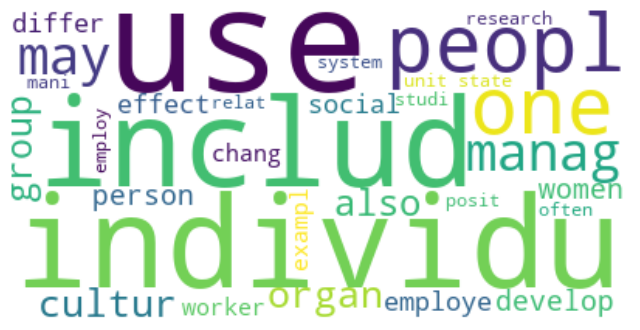

In [85]:
generate_wordcloud(content)

Generate Tokens Stats

In [86]:
output = 'output/token_table.csv'
generate_token_table(content_path, output)

Tableau sauvegardé dans output/token_table.csv


Clustering

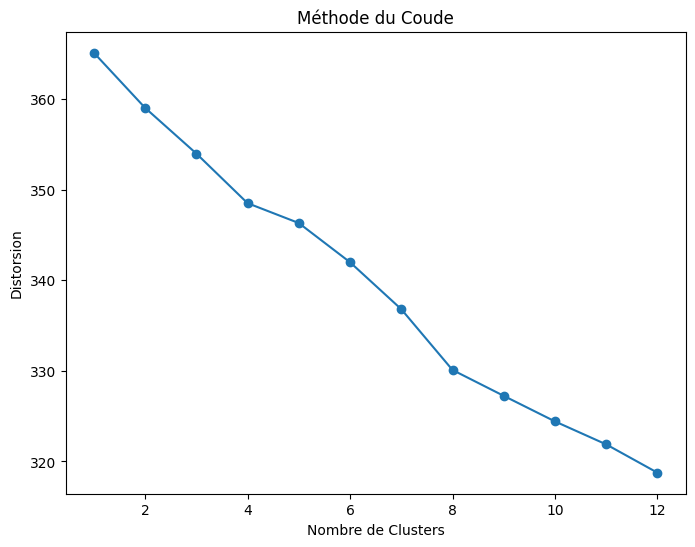

Nombre optimal de clusters : 8
Cluster 1 sauvegardé dans output/clusters/cluster_1.json
Cluster 6 sauvegardé dans output/clusters/cluster_6.json
Cluster 5 sauvegardé dans output/clusters/cluster_5.json
Cluster 2 sauvegardé dans output/clusters/cluster_2.json
Cluster 0 sauvegardé dans output/clusters/cluster_0.json
Cluster 4 sauvegardé dans output/clusters/cluster_4.json
Cluster 7 sauvegardé dans output/clusters/cluster_7.json
Cluster 3 sauvegardé dans output/clusters/cluster_3.json


In [87]:
num_clusters = find_optimal_clusters("content3.json", max_k=12)  
print(f'Nombre optimal de clusters : {num_clusters}')

clusters, similarity_matrix = cluster_documents("content3.json", num_clusters)

# Afficher et sauvegarder les contenus des clusters
save_clusters_individually(clusters, "content3.json")

In [88]:
clusters_dir = "output/clusters"
original_links_path = "links3.json"
output_dir = "cluster_links"

create_links_per_cluster(clusters_dir, original_links_path, output_dir)

Fichier de liens créé pour le cluster : cluster_links/cluster_6_links.json
Fichier de liens créé pour le cluster : cluster_links/cluster_7_links.json
Fichier de liens créé pour le cluster : cluster_links/cluster_0_links.json
Fichier de liens créé pour le cluster : cluster_links/cluster_1_links.json
Fichier de liens créé pour le cluster : cluster_links/cluster_2_links.json
Fichier de liens créé pour le cluster : cluster_links/cluster_3_links.json
Fichier de liens créé pour le cluster : cluster_links/cluster_4_links.json
Fichier de liens créé pour le cluster : cluster_links/cluster_5_links.json


JSON to GML

In [89]:
links = "links3.json"
output_file = "outputgml/graph.gml"
json_to_gml(links, output_file)

Fichier GML créé : outputgml/graph.gml


In [90]:
output_file1 = "outputgml/tokens_graph.gml"
output_file2 = "outputgml/clusters_graph.gml"
tokens_file = "output/cleaned_data.json"
clusters_file = "output/clusters.json"
json_to_gml(tokens_file, output_file1)
json_to_gml(clusters_file, output_file2)

Fichier GML créé : outputgml/tokens_graph.gml
Fichier GML créé : outputgml/clusters_graph.gml


In [91]:
output_file = "outputgml/similarity_graph.gml"
generate_similarity_graph(content, similarity_matrix, output_file)

Graphe de similarité créé : outputgml/similarity_graph.gml


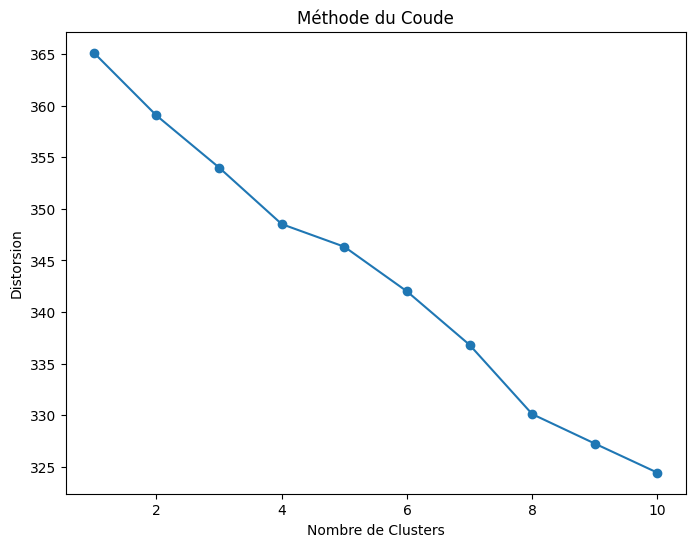

Fichier GML créé : outputgml/cluster_0.gml
Fichier GML créé : outputgml/cluster_1.gml
Fichier GML créé : outputgml/cluster_2.gml
Fichier GML créé : outputgml/cluster_3.gml
Fichier GML créé : outputgml/cluster_4.gml
Fichier GML créé : outputgml/cluster_5.gml
Fichier GML créé : outputgml/cluster_6.gml
Fichier GML créé : outputgml/cluster_7.gml


In [92]:
num_clusters = find_optimal_clusters("content3.json", max_k=10)
for i in range(0,num_clusters):
    json_to_gml(f"cluster_links/cluster_{i}_links.json", f"outputgml/cluster_{i}.gml")

In [108]:
print(analyze_page_sentiment("Sexual harassment", content))


{'page_name': 'Sexual harassment', 'sentiment_scores': {'positive': 0.04732241153342072, 'negative': 0.16626605504587172, 'neutral': 0.7824783748361731, 'compound': -0.3425870249017047}, 'overall_sentiment': 'Neutre avec consonance plus négative'}


In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Retirer les chiffres
    text = re.sub(r'\s+', ' ', text)  # Supprimer les espaces multiples
    return text.strip()

# Appliquer sur le contenu
content = {key: preprocess_text(value) for key, value in content.items()}
def tf(content):
    # Créer le vecteur TF-IDF
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(list(content.values()))
    
    # Extraire les termes et leurs spécificités (IDF)
    terms = vectorizer.get_feature_names_out()
    idf_values = vectorizer.idf_
    
    # Afficher la spécificité des mots
    print("Spécificité (IDF) des mots :")
    for term, idf in zip(terms, idf_values):
        print(f"{term}: {idf:.2f}")
    
    return X_tfidf  # Retourne la matrice TF-IDF pour d'autres usages


tf(content)


Spécificité (IDF) des mots :
aa: 5.85
aapi: 5.85
aarti: 5.34
aasce: 5.85
abacha: 5.85
abahlali: 5.85
abandon: 4.38
abandoned: 4.18
abandoning: 5.00
abandonment: 4.00
abasement: 5.16
abated: 5.16
abawi: 5.34
abbot: 5.34
abbott: 4.65
abbreviated: 5.34
abbreviation: 5.16
abbreviations: 5.56
abc: 5.00
abdelhadi: 5.85
abdomen: 5.85
abduction: 4.75
abducts: 5.16
aberbach: 5.85
aberle: 5.85
abide: 5.85
abilities: 3.12
abington: 5.85
able: 1.95
ableism: 4.65
ablution: 5.85
abnormal: 4.31
abnormality: 5.56
abolish: 4.38
abolished: 3.86
abolishing: 5.85
abolishment: 5.85
abolition: 4.24
abolitionism: 5.85
abolitionist: 4.87
abolitionists: 5.85
abomination: 5.34
aboriginal: 4.31
aboriginals: 5.56
aborigine: 5.85
aborigines: 5.00
abort: 5.56
abortion: 4.00
abortions: 5.56
abraham: 4.06
abrams: 5.56
abroad: 3.58
abrogated: 5.85
abs: 5.85
absence: 2.96
absences: 5.85
absent: 4.18
absentee: 5.16
absenteeism: 3.73
absolute: 3.42
absolutely: 5.56
absolutism: 5.85
absorb: 4.65
absorbed: 4.87
absorbing: 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 294627 stored elements and shape (382, 19566)>